# Introduction to single-cell Variational Inference (scVI)
In this introductory tutorial, we go through the different steps of a scVI workflow
1. Loading the data
2. Training the model
3. Retrieving the latent space and imputed values
4. Visualize the latent space with scanpy
5. Perform differential expression 
6. The special case of scVI for batch effect correction
7. Miscenalleous information

In [ ]:
%matplotlib inline

In [1]:
def allow_notebook_for_test():
    print("Testing the basic tutorial notebook")


test_mode = False
save_path = "data/"
n_epochs_all = None
show_plot = True

if not test_mode:
    save_path = "../../data"

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scvi.dataset import CortexDataset, RetinaDataset
from scvi.models import VAE
from scvi.inference import UnsupervisedTrainer
import torch

[2019-11-13 16:17:13,763] INFO - scvi._settings | Added StreamHandler with custom formatter to 'scvi' logger.
/home/ubuntu/anaconda3/envs/scvi/lib/python3.7/site-packages/scikit_learn-0.21.3-py3.7-linux-x86_64.egg/sklearn/utils/linear_assignment_.py:21: DeprecationWarning: The linear_assignment_ module is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


## Loading data

Let us first load the CORTEX dataset described in Zeisel et al. (2015). scVI has many "built-in" datasets as well as support for loading arbitrary .csv, .loom, and .h5ad (AnnData) files. Please see our [data loading Jupyter notebook](https://github.com/YosefLab/scVI/blob/master/tests/notebooks/data_loading.ipynb) for more examples of data loading.

* Zeisel, Amit, et al. "Cell types in the mouse cortex and hippocampus revealed by single-cell RNA-seq." Science 347.6226 (2015): 1138-1142. 

In [3]:
gene_dataset = CortexDataset(save_path=save_path, total_genes=558)

[2019-11-13 16:17:15,609] INFO - scvi.dataset.dataset | File /home/ubuntu/scVI/data/expression.bin already downloaded
[2019-11-13 16:17:15,610] INFO - scvi.dataset.cortex | Loading Cortex data
[2019-11-13 16:17:25,847] INFO - scvi.dataset.cortex | Finished preprocessing Cortex data
[2019-11-13 16:17:25,860] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2019-11-13 16:17:25,861] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]


In this demonstration and for this particular dataset, we use only 558 genes as in the original scVI publication. This was essentially for benchmarking purposes and we propose here a few practical rules for gene filtering with scVI:
+ If many cells are available, it is in general better to use as many genes as possible. Of course, it might be of interest to remove ad-hoc genes depending on the downstream analysis or the application. 
+ When the dataset is small, it is usually better to filter out genes to avoid overfitting. In the original scVI publication, we reported poor imputation performance for when the number of cells was lower than the number of genes. This is all empirical and in general, it is hard to predict what the optimal number of genes will be.
+ The default scVI code will filter genes based on variance. We advise relying on scanpy and then importing the **unnormalized** filtered matrix into scVI for more complex filtering schemes. 

## Training

* __n_epochs__: Maximum number of epochs to train the model. If the likelihood change is small than a set threshold training will stop automatically. 
* __lr__: learning rate. Set to 0.001 here. 
* __use_batches__: If the value of true than batch information is used in the training. Here it is set to false because the cortex data only contains one batch. 
* __use_cuda__: Set to true to use CUDA (GPU required) 


In [4]:
n_epochs = 400 if n_epochs_all is None else n_epochs_all
lr = 1e-3
use_batches = False
use_cuda = True

We now create the model and the trainer object. We train the model and output model likelihood every 5 epochs. In order to evaluate the likelihood on a test set, we split the datasets (the current code can also so train/validation/test).

If a pre-trained model already exist in the save_path then load the same model rather than re-training it. This is particularly useful for large datasets.

In [5]:
vae = VAE(gene_dataset.nb_genes, n_batch=gene_dataset.n_batches * use_batches)
trainer = UnsupervisedTrainer(
    vae,
    gene_dataset,
    train_size=0.75,
    use_cuda=use_cuda,
    frequency=5,
)

if os.path.isfile('%s/vae.pkl' % save_path):
    trainer.model.load_state_dict(torch.load('%s/vae.pkl' % save_path))
    trainer.model.eval()
else:
    trainer.train(n_epochs=n_epochs, lr=lr)
    torch.save(trainer.model.state_dict(), '%s/vae.pkl' % save_path)

training: 100%|██████████| 400/400 [01:36<00:00,  4.14it/s]


**Plotting the likelihood change across the 500 epochs of training: blue for training error and orange for testing error.**

(1150, 1600)

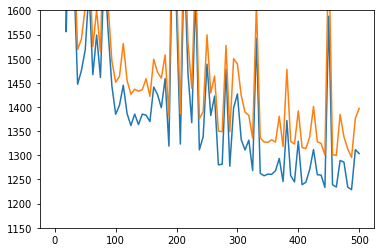

In [6]:
elbo_train_set = trainer.history["elbo_train_set"]
elbo_test_set = trainer.history["elbo_test_set"]
x = np.linspace(0, 500, (len(elbo_train_set)))
plt.plot(x, elbo_train_set)
plt.plot(x, elbo_test_set)
plt.ylim(1150, 1600)

## Obtaining the posterior object and sample latent space as well as imputation from it

The posterior object contains a model and a gene_dataset, as well as additional arguments that for Pytorch's `DataLoader`. It also comes with many methods or utilities querying the model, such as differential expression, imputation and differential analyisis.


To get an ordered output result, we might use `.sequential` posterior's method which return another instance of posterior (with shallow copy of all its object references), but where the iteration is in the same ordered as its  indices attribute.

In [7]:
full = trainer.create_posterior(trainer.model, gene_dataset, indices=np.arange(len(gene_dataset)))
latent, batch_indices, labels = full.sequential().get_latent()
batch_indices = batch_indices.ravel()

Similarly, it is possible to query the imputed values via the `imputation` method of the posterior object. **Note for advanced users:** imputation is an ambiguous term and there are two ways to perform imputation in scVI. The first way is to query the **mean of the negative binomial** distribution modeling the counts. This is referred to as `sample_rate` in the codebase and can be reached via the `imputation` method. The second is to query the **normalized mean of the same negative binomial** (please refer to the scVI manuscript). This is referred to as `sample_scale` in the codebase and can be reached via the `get_sample_scale` method. In differential expression for example, we of course rely on the normalized latent variable which is corrected for variations in sequencing depth.

In [8]:
imputed_values = full.sequential().imputation()
normalized_values = full.sequential().get_sample_scale()

## Visualizing the latent space with scanpy

scanpy is a handy and powerful python library for visualization and downstream analysis of single-cell RNA sequencing data. We show here how to feed the latent space of scVI into a scanpy object and visualize it using UMAP as implemented in scanpy. More on how scVI can be used with scanpy on [this notebook](https://github.com/YosefLab/scVI/blob/master/tests/notebooks/scanpy_pbmc3k.ipynb). **Note to advanced users:** The code 'get_latent' returns only the mean of the posterior distribution for the latent space. However, we recover a full distribution with our inference framework. Let us keep in mind that the latent space visualized here is a practical summary of the data only. Uncertainty is needed for other downstream analyses such as differential expression. 

In [9]:
import scanpy as sc
import anndata

In [10]:
post_adata = anndata.AnnData(X=gene_dataset.X)
post_adata.obsm["X_scVI"] = latent
post_adata.obs['cell_type'] = np.array([gene_dataset.cell_types[gene_dataset.labels[i][0]]  
                                        for i in range(post_adata.n_obs)])
sc.pp.neighbors(post_adata, use_rep="X_scVI", n_neighbors=15)
sc.tl.umap(post_adata, min_dist=0.1)

... storing 'cell_type' as categorical


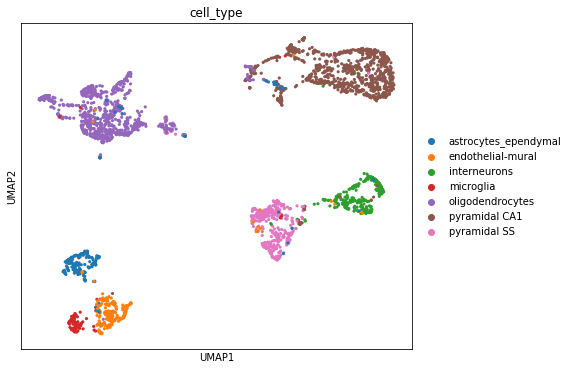

In [11]:
fig, ax = plt.subplots(figsize=(7, 6))
sc.pl.umap(post_adata, color=["cell_type"], ax=ax, show=show_plot)

The user will note that we imported curated labels from the original publication. Our interface with scanpy makes it easy to cluster the data with scanpy from scVI's latent space and then reinject them into scVI for differential expression, which we now discuss.

## Differential Expression
From the trained VAE model we can sample the gene expression rate for each gene in each cell. For the two populations of interest, we can then randomly sample pairs of cells, one from each population to compare their expression rate for a gene. The degree of differential expression is measured by __logit(p/(1-p))__ where __p__ is the probability of a cell from population A having a higher expression than a cell from population B. We can form the null distribution of the DE values by sampling pairs randomly from the combined population.

The following example is implemented for the cortext dataset, vary __cell_types__ and __genes_of_interest__ for other datasets. 

**1. Set population A and population B for comparison**

In [12]:
cell_types = gene_dataset.cell_types
print(gene_dataset.cell_types)
# oligodendrocytes (#4) VS pyramidal CA1 (#5)
couple_celltypes = (4, 5)  # the couple types on which to study DE

print("\nDifferential Expression A/B for cell types\nA: %s\nB: %s\n" %
      tuple((cell_types[couple_celltypes[i]] for i in [0, 1])))

cell_idx1 = gene_dataset.labels.ravel() == couple_celltypes[0]
cell_idx2 = gene_dataset.labels.ravel() == couple_celltypes[1]

['astrocytes_ependymal' 'endothelial-mural' 'interneurons' 'microglia'
 'oligodendrocytes' 'pyramidal CA1' 'pyramidal SS']

Differential Expression A/B for cell types
A: oligodendrocytes
B: pyramidal CA1



**2. Define parameters**
* __n_samples__: the number of times to sample __px_scales__ from the vae model for each gene in each cell.
* __M_permutation__: Number of pairs sampled from the px_scales values for comparison.

In [13]:
n_samples = 100
M_permutation = 100000

In [14]:
de_res = full.differential_expression_score(
    cell_idx1, 
    cell_idx2, 
    n_samples=n_samples, 
    M_permutation=M_permutation,
)

[2019-11-13 16:19:18,606] INFO - scvi.inference.posterior | Differential expression using vanilla mode
INFO:scvi.inference.posterior:Differential expression using vanilla mode


**3. Print out the differential expression value**
* bayes_factor: The bayes factor for cell type 1 having a higher expression than cell type 2
* raw_mean*i*: average UMI counts in cell type *i*
* non_zeros_proportion*i*: proportion of non-zero expression in cell type *i*
* raw_normalized_mean*i*: average UMI counts in cell type *i* normalized by cell size
* scale*i*: average scVI imputed gene expression scale in cell type *i* 


In [15]:
genes_of_interest = ["THY1", "MBP"]
de_res.filter(items=genes_of_interest, axis=0)

,proba_m1,proba_m2,bayes_factor,scale1,scale2,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2
THY1,0.00191,0.99809,-6.258735,0.000168,0.001827,0.589024,13.569755,0.219512,0.996805,0.060620,1.037373
MBP,0.99481,0.00519,5.255816,0.011276,0.000388,55.318295,2.787008,0.998780,0.452609,5.862774,0.210483


**9. Visualize top 10 most expressed genes per cell types**

In [16]:
per_cluster_de, cluster_id = full.one_vs_all_degenes(cell_labels=gene_dataset.labels.ravel(), min_cells=1)

markers = []
for x in per_cluster_de:
    markers.append(x[:10])
markers = pd.concat(markers)

genes = np.asarray(markers.index)
expression = [x.filter(items=genes, axis=0)['raw_normalized_mean1'] for x in per_cluster_de]
expression = pd.concat(expression, axis=1)
expression = np.log10(1 + expression)
expression.columns = gene_dataset.cell_types

[2019-11-13 16:19:18,878] INFO - scvi.inference.posterior | Differential expression using vanilla mode
INFO:scvi.inference.posterior:Differential expression using vanilla mode
[2019-11-13 16:19:18,909] INFO - scvi.inference.posterior | Differential expression using vanilla mode
INFO:scvi.inference.posterior:Differential expression using vanilla mode
[2019-11-13 16:19:18,940] INFO - scvi.inference.posterior | Differential expression using vanilla mode
INFO:scvi.inference.posterior:Differential expression using vanilla mode
[2019-11-13 16:19:18,970] INFO - scvi.inference.posterior | Differential expression using vanilla mode
INFO:scvi.inference.posterior:Differential expression using vanilla mode
[2019-11-13 16:19:19,000] INFO - scvi.inference.posterior | Differential expression using vanilla mode
INFO:scvi.inference.posterior:Differential expression using vanilla mode
[2019-11-13 16:19:19,030] INFO - scvi.inference.posterior | Differential expression using vanilla mode
INFO:scvi.inferen

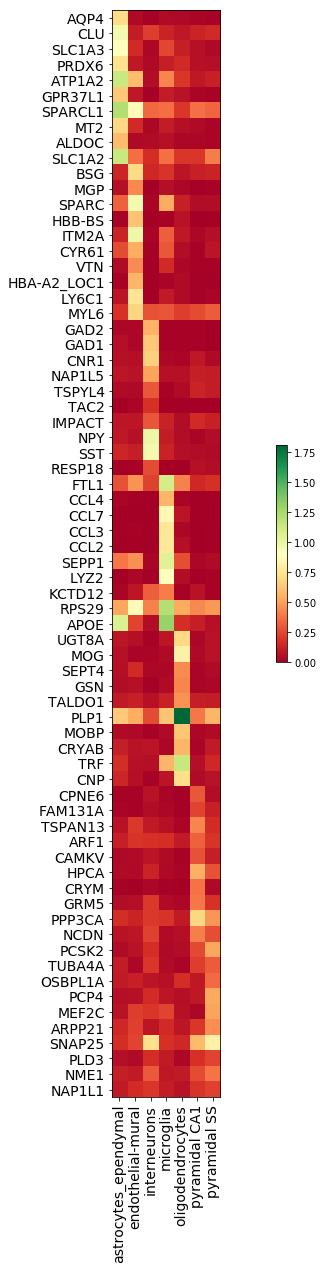

In [17]:
plt.figure(figsize=(20, 20))
im = plt.imshow(expression, cmap='RdYlGn', interpolation='none', aspect='equal')
ax = plt.gca()
ax.set_xticks(np.arange(0, 7, 1))
ax.set_xticklabels(gene_dataset.cell_types, rotation='vertical')
ax.set_yticklabels(genes)
ax.set_yticks(np.arange(0, 70, 1))
ax.tick_params(labelsize=14)
plt.colorbar(shrink=0.2)

## Correction for batch effects

We now load the RETINA dataset that is described in Shekhar et al. (2016) for an example of batch-effect correction. For more extensive utilization, we encourage the users to visit the [harmonization](https://github.com/YosefLab/scVI/blob/master/tests/notebooks/harmonization.ipynb) as well as the [annotation](https://github.com/YosefLab/scVI/blob/master/tests/notebooks/annotation.ipynb) notebook which explain in depth how to deal with several datasets (in an unsupervised or semi-supervised fashion). 

* Shekhar, Karthik, et al. "Comprehensive classification of retinal bipolar neurons by single-cell transcriptomics." Cell 166.5 (2016): 1308-1323.

In [18]:
retina_dataset = RetinaDataset(save_path=save_path)

[2019-11-13 16:19:20,519] INFO - scvi.dataset.dataset | File /home/ubuntu/scVI/data/retina.loom already downloaded
INFO:scvi.dataset.dataset:File /home/ubuntu/scVI/data/retina.loom already downloaded
[2019-11-13 16:19:20,520] INFO - scvi.dataset.loom | Preprocessing dataset
INFO:scvi.dataset.loom:Preprocessing dataset
[2019-11-13 16:19:31,587] INFO - scvi.dataset.loom | Finished preprocessing dataset
INFO:scvi.dataset.loom:Finished preprocessing dataset
[2019-11-13 16:19:33,562] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
INFO:scvi.dataset.dataset:Remapping labels to [0,N]
[2019-11-13 16:19:33,565] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
INFO:scvi.dataset.dataset:Remapping batch_indices to [0,N]


In [19]:
n_epochs = 50 if n_epochs_all is None else n_epochs_all
lr = 1e-3
use_batches = True
use_cuda = True

# Train the model and output model likelihood every 5 epochs
vae = VAE(retina_dataset.nb_genes, n_batch=retina_dataset.n_batches * use_batches)
trainer = UnsupervisedTrainer(
    vae, 
    retina_dataset, 
    train_size=0.9 if not test_mode else 0.5, 
    use_cuda=use_cuda,
    frequency=5,
)
trainer.train(n_epochs=n_epochs, lr=lr)

training: 100%|██████████| 50/50 [02:54<00:00,  3.49s/it]


(2925.857857678191, 3500)

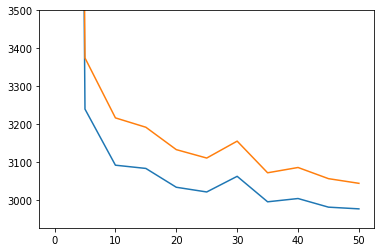

In [20]:
# Plotting the likelihood change across the 50 epochs of training: 
# blue for training error and orange for testing error. 

elbo_train = trainer.history["elbo_train_set"]
elbo_test = trainer.history["elbo_test_set"]
x = np.linspace(0, 50, (len(elbo_train)))
plt.plot(x, elbo_train)
plt.plot(x, elbo_test)
plt.ylim(min(elbo_train)-50, 3500)

**Computing batch mixing**

In [21]:
full = trainer.create_posterior(trainer.model, retina_dataset, indices=np.arange(len(retina_dataset)))
print("Entropy of batch mixing :", full.entropy_batch_mixing())

Entropy of batch mixing : 0.6008383450165736


**Visualizing the mixing**

In [22]:
full = trainer.create_posterior(trainer.model, retina_dataset, indices=np.arange(len(retina_dataset)))
latent, batch_indices, labels = full.sequential().get_latent()

In [25]:
post_adata = anndata.AnnData(X=retina_dataset.X)
post_adata.obsm["X_scVI"] = latent
post_adata.obs['cell_type'] = np.array([retina_dataset.cell_types[retina_dataset.labels[i][0]] 
                                   for i in range(post_adata.n_obs)])
post_adata.obs['batch'] = np.array([retina_dataset.batch_indices[i][0] 
                                   for i in range(post_adata.n_obs)])
sc.pp.neighbors(post_adata, use_rep="X_scVI", n_neighbors=15)
sc.tl.umap(post_adata, min_dist=0.1)

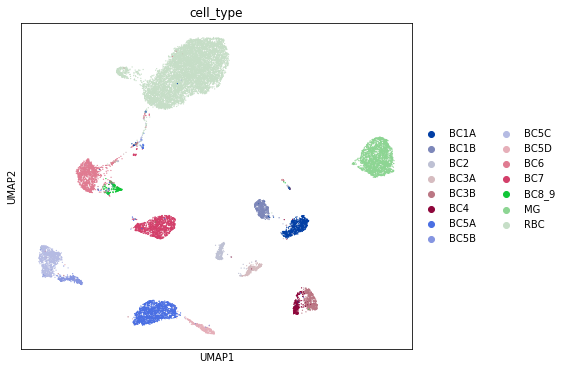

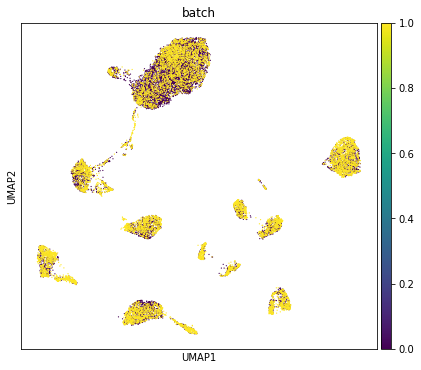

In [26]:
fig, ax = plt.subplots(figsize=(7, 6))
sc.pl.umap(post_adata, color=["cell_type"], ax=ax, show=show_plot)
fig, ax = plt.subplots(figsize=(7, 6))
sc.pl.umap(post_adata, color=["batch"], ax=ax, show=show_plot)

## Logging information

Verbosity varies in the following way:
* `logger.setLevel(logging.WARNING)` will show a progress bar.
* `logger.setLevel(logging.INFO)` will show global logs including the number of jobs done.
* `logger.setLevel(logging.DEBUG)` will show detailed logs for each training (e.g the parameters tested).

This function's behaviour can be customized, please refer to its documentation for information about the different parameters available.

In general, you can use `scvi.set_verbosity(level)` to set the verbosity of the scvi package.
Note that `level` corresponds to the logging levels of the standard python `logging` module. By default, that level is set to `INFO` (=20).
As a reminder the logging levels are:
<table class="docutils align-center">
<colgroup>
<col style="width: 48%">
<col style="width: 52%">
</colgroup>
<thead>
<tr class="row-odd"><th class="head"><p>Level</p></th>
<th class="head"><p>Numeric value</p></th>
</tr>
</thead>
<tbody>
<tr class="row-even"><td><p><code class="docutils literal notranslate"><span class="pre">CRITICAL</span></code></p></td>
<td><p>50</p></td>
</tr>
<tr class="row-odd"><td><p><code class="docutils literal notranslate"><span class="pre">ERROR</span></code></p></td>
<td><p>40</p></td>
</tr>
<tr class="row-even"><td><p><code class="docutils literal notranslate"><span class="pre">WARNING</span></code></p></td>
<td><p>30</p></td>
</tr>
<tr class="row-odd"><td><p><code class="docutils literal notranslate"><span class="pre">INFO</span></code></p></td>
<td><p>20</p></td>
</tr>
<tr class="row-even"><td><p><code class="docutils literal notranslate"><span class="pre">DEBUG</span></code></p></td>
<td><p>10</p></td>
</tr>
<tr class="row-odd"><td><p><code class="docutils literal notranslate"><span class="pre">NOTSET</span></code></p></td>
<td><p>0</p></td>
</tr>
</tbody>
</table>